
# Assignment 3

This is a template notebook for Assignment 3.


## Install dependencies and initialization

In [ ]:
# The next 8 lines added to be compatible with version changes (2022/10/13).
# change cuda to 11.1
import os
p = os.getenv('PATH')
ld = os.getenv('LD_LIBRARY_PATH')
os.environ['PATH'] = f"/usr/local/cuda-11.1/bin:{p}"
os.environ['LD_LIBRARY_PATH'] = f"/usr/local/cuda-11.1/lib64:{ld}"
# change pytorch to 1.9.0 compiled with cuda 11.1
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html


# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
!pip install detectron2 -f "https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html"

In [1]:
!pwd # shows current directory
!ls  # shows all files in this directory
!nvidia-smi # shows the specs and the current status of the allocated GPU
!nvidia-smi

/mnt
'=2.0.1'	 Visual2_1.png		        input.jpg	  output
 Visual1_0.png	 Visual2_2.png		        lab3.ipynb	  output1
 Visual1_1.png	 data			        log.txt		  pred.csv
 Visual1_2.png	 final_segmentation_model.pth   model_final.pth
 Visual2_0.png	 inference.txt		        new_data
Thu Mar  2 02:30:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.54       Driver Version: 510.54       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    On   | 00000000:04:00.0 Off |                  Off |
| 41%   41C    P8    17W / 140W |      1MiB / 163

In [2]:
# import some common libraries
#from google.colab.patches import cv2_imshow
from sklearn.metrics import jaccard_score
from PIL import Image, ImageDraw
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import datetime
import random
import json
import cv2
import csv
import os

# import some common pytorch utilities
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch
import glob
from torchvision.ops.boxes import nms

# import some common detectron2 utilities
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import build_detection_test_loader
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
setup_logger()

<Logger detectron2 (DEBUG)>

In [3]:
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

torch:  1.10 ; cuda:  cu113
detectron2: 0.6


In [4]:
# Make sure that GPU is available for your notebook.
# Otherwise, you need to update the settungs in Runtime -> Change runtime type -> Hardware accelerator
IS_GPU = torch.cuda.is_available()

In [5]:
# You need to mount your google drive in order to load the data:
# from google.colab import drive
# drive.mount('/content/drive')
# Put all the corresponding data files in a data folder and put the data folder in a same directory with this notebook.
# Also create an output directory for your files such as the trained models and the output images.

In [6]:
# Define the location of current directory, which should contain data/train, data/test, and data/train.json.
# TODO: approx 1 line
# BASE_DIR = '/content/drive/My Drive/Colab Notebooks/03-cnn-detection-segmentation'
BASE_DIR = '.'
OUTPUT_DIR = '{}/output'.format(BASE_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(OUTPUT_DIR)

./output


Read the pictrue

/root/miniconda3/envs/myconda/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/root/miniconda3/envs/myconda/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<class 'torch.Tensor'>
<class 'detectron2.structures.boxes.Boxes'>
<class 'torch.Tensor'>



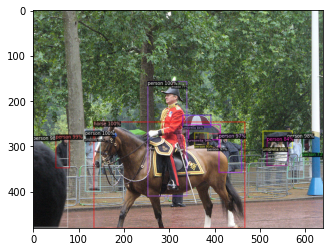

In [7]:
im = cv2.imread("input.jpg")
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
print(type(outputs["instances"].pred_classes))
print(type(outputs["instances"].pred_boxes[0]))
print(type(outputs["instances"].scores))
print()
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

q## Part 1: Object Detection

### Data Loader

In [8]:
'''
# This function should return a list of data samples in which each sample is a dictionary. 
# Make sure to select the correct bbox_mode for the data
# For the test data, you only have access to the images, therefore, the annotations should be empty.
# Other values could be obtained from the image files.
# TODO: approx 35 lines
'''
from detectron2.structures import BoxMode
def get_detection_data(set_name):
  data_dirs = '{}/data'.format(BASE_DIR)
  img_dirs = os.path.join(data_dirs,set_name)
  dataset = []
  imgs_anns = []
  json_file = os.path.join(data_dirs, '{}.json'.format(set_name))
  with open(json_file) as f:
    imgs_anns = json.load(f)
  id = 0
  for img in glob.glob(os.path.join(img_dirs,'*.png')):
    img_name = os.path.basename(img)
    height,width = cv2.imread(img).shape[:2]
    record = {}
    record["file_name"] = img
    record["height"] = height
    record["width"] = width
    record["image_id"] = id
    anns = list(filter(lambda sample:sample["file_name"] == img_name,imgs_anns))
    annotations = []
    bbox_id = 0
    for ann in anns:
        obj = {
            "bbox": ann["bbox"],
            "bbox_mode": BoxMode.XYWH_ABS,
            "segmentation":ann["segmentation"],
            "category_id": 0,
            "idx":bbox_id,
            "iscrowd":ann['iscrowd']
        }
        annotations.append(obj)
        bbox_id += 1
    record["annotations"] = annotations
    dataset.append(record)
    id+=1
  return dataset

In [9]:
'''
# Remember to add your dataset to DatasetCatalog and MetadataCatalog
# Consdier "data_detection_train" and "data_detection_test" for registration
# You can also add an optional "data_detection_val" for your validation by spliting the training data
# TODO: approx 5 lines
'''
# def data_detection_(set_name):
#     dict = get_detection_data('train')
#     length = int(len(dict)/5)
#     if set_name == "train":
#         return dict[length:]
#     elif set_name == "val":
#         return dict[:length]
#     return []

for d in ["train", "val","test","new_train"]:
    DatasetCatalog.register("data_detection_" + d, lambda e=d:get_detection_data(e))
    MetadataCatalog.get("data_detection_" + d).set(thing_classes=["plane"])


./data/val/P00269.png
./data/val/P00043.png
./data/val/P00250.png


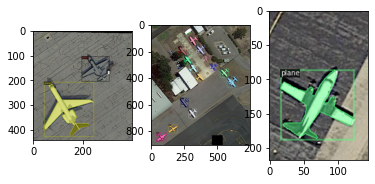

In [10]:
'''
# Visualize some samples using Visualizer to make sure that the function works correctly
# TODO: approx 5 lines
'''
from random import sample
data_dicts = DatasetCatalog.get("data_detection_val")
plane_metadata = MetadataCatalog.get("data_detection_val")
fig, aix = plt.subplots(1,3)
id = 0
for d in sample(data_dicts,3):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=plane_metadata, scale=1.0,)
    out = visualizer.draw_dataset_dict(d)
    aix[id].imshow(cv2.cvtColor(out.get_image()[:, :, ::-1],cv2.COLOR_BGR2RGB))
    id+=1

    ### Set Configs

In [11]:
'''
# Set the configs for the detection part in here.
# TODO: approx 15 lines
'''
cfg = get_cfg()
cfg.OUTPUT_DIR = "{}/output/".format(BASE_DIR)
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("data_detection_new_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4 # Windows: 0, Linux 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 4 #in processed data
cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.MAX_ITER = 2500
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.TEST.EVAL_PERIOD = 1000


### Training

In [12]:
'''
# Create a DefaultTrainer using the above config and train the model
# TODO: approx 5 lines
'''

evaluator = COCOEvaluator("data_detection_val",output_dir="./output")

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, output_folder=None):
        return evaluator

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/02 02:30:22 d2.evaluation.coco_evaluation]: Trying to convert 'data_detection_val' to COCO format ...
WARNING [03/02 02:30:22 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/data_detection_val_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[03/02 02:30:24 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[03/02 02:32:39 d2.engine.train_loop]: Starting training from iteration 0


/root/miniconda3/envs/myconda/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[03/02 02:32:57 d2.utils.events]:  eta: 0:41:52  iter: 19  total_loss: 1.678  loss_cls: 0.717  loss_box_reg: 0.6368  loss_rpn_cls: 0.2082  loss_rpn_loc: 0.03189  time: 0.7791  data_time: 0.1176  lr: 1.9981e-06  max_mem: 8761M
[03/02 02:33:18 d2.utils.events]:  eta: 0:42:10  iter: 39  total_loss: 1.658  loss_cls: 0.701  loss_box_reg: 0.6434  loss_rpn_cls: 0.1389  loss_rpn_loc: 0.04862  time: 0.9215  data_time: 0.2558  lr: 3.9961e-06  max_mem: 8761M
[03/02 02:33:38 d2.utils.events]:  eta: 0:41:53  iter: 59  total_loss: 1.68  loss_cls: 0.68  loss_box_reg: 0.6575  loss_rpn_cls: 0.1599  loss_rpn_loc: 0.04467  time: 0.9352  data_time: 0.1775  lr: 5.9941e-06  max_mem: 8761M
[03/02 02:33:57 d2.utils.events]:  eta: 0:41:55  iter: 79  total_loss: 1.57  loss_cls: 0.6436  loss_box_reg: 0.6035  loss_rpn_cls: 0.2783  loss_rpn_loc: 0.08372  time: 0.9481  data_time: 0.1670  lr: 7.9921e-06  max_mem: 8761M
[03/02 02:34:15 d2.utils.events]:  eta: 0:42:13  iter: 99  total_loss: 1.541  loss_cls: 0.6212  lo

### Evaluation and Visualization

In [13]:
'''
    After data processor, when input high resolution images
'''
from torchvision.ops.boxes import nms, _box_xywh_to_xyxy, _box_xyxy_to_xywh
from detectron2.structures import instances, Boxes
class my_predictor():
    def __init__(self, model, height, width, stride, threshold):
        self.predictor = model
        self.height = height
        self.width = width
        self.stride = stride
        self.boxes = torch.tensor([]).cuda()
        self.score = torch.tensor([]).cuda()
        self.classes = torch.tensor([]).cuda()
        self.threshold = threshold

    def predict(self, img):
        self.boxes = torch.tensor([]).cuda()
        self.score = torch.tensor([]).cuda()
        self.classes = torch.tensor([]).cuda()
        img_height, img_weight = img.shape[:2]
        origin_pred = self.predictor(img)
        boxes = origin_pred['instances'].pred_boxes
        for box in boxes:
            self.boxes = torch.cat((self.boxes,box[None,:]),dim=0)
        self.score = origin_pred['instances'].scores
        self.classes = origin_pred['instances'].pred_classes
        col, row = [0, 0]
        for i in range(0,img_height,self.stride):
            row = 0
            for j in range(0,img_weight, self.stride):
                img_crop = img[i:i+self.stride, j:j+self.stride,:]
                pred = self.predictor(img_crop)
                score = pred['instances'].scores
                boxes = pred['instances'].pred_boxes
                classes = pred['instances'].pred_classes
                for box in boxes:
                    box[0] += j
                    box[1] += i
                    box[2] += j
                    box[3] += i
                    self.boxes = torch.cat((self.boxes,box[None,:]),dim=0)
                self.score = torch.cat((self.score,score),dim=0)
                self.classes = torch.cat((self.classes,classes),dim=0)
                row +=1
            col+=1
        if self.boxes.nelement() == 0:
            idx = torch.tensor([],dtype=torch.int64)
        else:
            idx = nms(boxes=self.boxes, scores=self.score, iou_threshold=self.threshold)
        out = instances.Instances(
            (img_height,img_weight),
            pred_classes=self.classes[idx].to('cpu'),
            pred_boxes=Boxes(self.boxes[idx].to('cpu')),
            scores=self.score[idx].to('cpu')
        )
        return out

In [14]:
'''
# After training the model, you need to update cfg.MODEL.WEIGHTS
# Define a DefaultPredictor
'''
print(cfg.OUTPUT_DIR)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.90  # set a custom testing threshold
predictor = my_predictor(DefaultPredictor(cfg),512,512,256,0.2)
# predictor = DefaultPredictor(cfg)

./output/


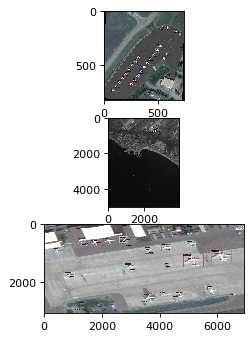

In [15]:
'''
# Visualize the output for 3 random test samples
# TODO: approx 10 lines
'''
from detectron2.utils.visualizer import ColorMode
test_dict = get_detection_data('test')
plt.rcParams['figure.figsize'] = [10, 5]

fig, aix = plt.subplots(3,1,dpi=80)
idx = 0
for d in random.sample(test_dict,3):
    im = cv2.imread(d["file_name"])  
    # ------------------ conv and merge here

    outputs = predictor.predict(im)
    v = Visualizer(im[:, :, :],
                   metadata=plane_metadata,
                   scale=1.0,
                   instance_mode=ColorMode.IMAGE  # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs)
    aix[idx].imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB),origin='upper', interpolation='nearest')
    cv2.imwrite("./output/Out{}.png".format(idx),out.get_image()[:, :, ::-1])
    idx+=1

plt.show()

In [16]:
'''
# Use COCOEvaluator and build_detection_train_loader
# You can save the output predictions using inference_on_dataset
# TODO: approx 5 lines
'''
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("data_detection_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "data_detection_val")
with open("inference.txt","w") as f:
    a = inference_on_dataset(DefaultPredictor(cfg).model, val_loader, evaluator)
    print(a)
    f.write(str(a))
    f.close()

[03/02 03:20:43 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   plane    | 1430         |
|            |              |
[03/02 03:20:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/02 03:20:43 d2.data.common]: Serializing 270 elements to byte tensors and concatenating them all ...
[03/02 03:20:43 d2.data.common]: Serialized dataset takes 2.14 MiB
[03/02 03:20:47 d2.evaluation.evaluator]: Start inference on 270 batches
[03/02 03:20:48 d2.evaluation.evaluator]: Inference done 11/270. Dataloading: 0.0011 s/iter. Inference: 0.0971 s/iter. Eval: 0.0003 s/iter. Total: 0.0984 s/iter. ETA=0:00:25
[03/02 03:20:53 d2.evaluation.evaluator]: Inference done 45/270. Dataloading: 0.0353 s/iter. Inference: 0.1046 s/iter. Eval: 0.0003 s/iter. Total: 0.1402 s/iter. ETA=0:00:31
[03/02 03:20:59 d2.evaluat

### Improvements

For this part, you can bring any improvement which you have by adding new input parameters to the previous functions or defining new functions and variables.

In [17]:
'''
# Bring any changes and updates regarding the improvement in here
Output: a new generated training set and corresponding Json file.
inorder to generate the new test set, please make the directory as follows: "./new_data/train" in the same path as this program
When using the new generated set, please use the data loader at beginning
'''
import itertools
from math import sqrt
from detectron2.utils.visualizer import GenericMask
def slice_tuple(slice_,scale):
    return slice_.start*scale, slice_.stop*scale

## data preprocessing,with will generate a new training folder and json
from scipy.ndimage import label,find_objects
def preprocess_data(data_dicts):
    new_json = []
    picture_id = 0
    annotation_id = 0
    new_data_pth = "{}/data/".format(BASE_DIR)
    for id, dict in enumerate(data_dicts):
        # print(dict['file_name'])
        maxbbox_W = 128 # int(max(dict['annotations'], key=lambda w:w['bbox'][2])['bbox'][2]*1)
        maxbbox_H = 128 # int(max(dict['annotations'], key=lambda w:w['bbox'][3])['bbox'][3]*1)
        annotation_map = np.zeros([int(dict['height'] / maxbbox_H) + 1, int(dict['width'] / maxbbox_W) + 1])
        # print("max W:{}, max H:{}, annotation size: {}".format(maxbbox_W,maxbbox_H,len(dict['annotations'])))
        # annotate the mapping of plane and the picture
        slice_area = 0
        for ann in dict['annotations']:
            [x,y,w,h] = ann['bbox']
            annotation_map[int((y-h)/maxbbox_H):int((y + h)/maxbbox_H) + 1,
                           int((x-w)/maxbbox_W):int((x + w)/maxbbox_W) + 1]  = 1
        labeded, labels = label(annotation_map)
        img = cv2.imread(dict['file_name'])
        #redistribute the json
        for ann in dict['annotations']:
            [x,y,w,h] = ann['bbox']
            ann_lable = int(labeded[int(y/maxbbox_H),
                                    int(x/maxbbox_W)])
            s1 = find_objects(labeded==ann_lable)
            img_hs, img_he = slice_tuple(s1[0][0],maxbbox_H)
            img_ws, img_we = slice_tuple(s1[0][1],maxbbox_W)
            new_segmentation = list(itertools.chain.from_iterable(zip(
                list(map(lambda x: x - img_ws, ann['segmentation'][0][::2])),
                list(map(lambda y: y - img_hs, ann['segmentation'][0][1::2]))
            )))
            new_ann_object = {
                'id': annotation_id,
                'img_id': picture_id + annotation_id,
                'segmentation': [new_segmentation],
                'catagory_id': ann['category_id'],
                'area': len(new_segmentation),
                'iscrowd': ann['iscrowd'],
                'bbox': [x-img_ws, y-img_hs, w, h],
                'file_name': "P{:05}.png".format(picture_id+ann_lable),
            }
            annotation_id+=1
            new_json.append(new_ann_object)
        #
        # # slice the image, and generate new annotation
        for label_ in range(1, labels+1):
            img_copy = img.copy()
            for ann in dict['annotations']:
                [x,y,w,h] = ann['bbox']
                ann_lable = int(labeded[int(y/maxbbox_H),
                                        int(x/maxbbox_W)])
                if (ann_lable != label_ and ann_lable != 0) or ann['iscrowd'] == 1:
                    img_copy[int(y - h/2):int(y+h/2),int(x-w/2):int(x+w/2)] = 0
            s1 = find_objects(labeded==label_)
            img_hs, img_he = slice_tuple(s1[0][0],maxbbox_H)
            img_ws, img_we = slice_tuple(s1[0][1],maxbbox_W)
            img_crop = img_copy[int(img_hs):int(img_he),
                                int(img_ws):int(img_we),:]
            if  np.all(img_crop == 0):
                img_crop = img[int(img_hs):int(img_he),
                               int(img_ws):int(img_we),:]
            picture_id+=1
            img_name = os.path.join(new_data_pth,"new_train/P{:05}.png".format(picture_id))
            cv2.imwrite(img_name,img_crop)

    js_string = json.dumps(new_json)
    with open(os.path.join(new_data_pth,'new_train.json'),'w') as f:
            f.write(js_string)
            f.close()
# data_dicts = DatasetCatalog.get("data_detection_train")
# preprocess_data(data_dicts)

## Part 2: Semantic Segmentation

### Data Loader

In [18]:
'''
# Write a function that returns the cropped image and corresponding mask regarding the target bounding box
# idx is the index of the target bbox in the data
# high-resolution image could be passed or could be load from data['file_name']
# You can use the mask attribute of detectron2.utils.visualizer.GenericMask 
#     to convert the segmentation annotations to binary masks
# TODO: approx 10 lines
'''
from detectron2.utils.visualizer import GenericMask
def get_instance_sample(data, idx, img=None):
    l_img = img
    if l_img == None:
        l_img = cv2.imread(data['file_name'])
    height = data['height']
    width = data['width']
    ann = list(filter(lambda plane: plane['idx'] == idx[1], data['annotations']))[0]
    m = GenericMask(ann['segmentation'],height, width)
    x = int(ann['bbox'][0])
    y = int(ann['bbox'][1])
    w = int(ann['bbox'][2])
    h = int(ann['bbox'][3])
    obj_img = cv2.resize(l_img[y:y+h,x:x+w],(128,128),interpolation = cv2.INTER_AREA)
    obj_mask = cv2.resize(m.mask[y:y+h,x:x+w],(128,128),interpolation = cv2.INTER_AREA)[np.newaxis,:,:]
    return obj_img , obj_mask

(1, 128, 128)


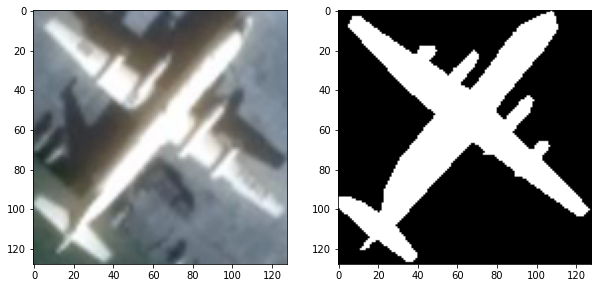

In [19]:
from torch.nn.functional import interpolate
data_dicts = DatasetCatalog.get("data_detection_train")
obj_img, obj_mask = get_instance_sample(data_dicts[1],[1,4],None)
# plt.imshow(obj_mask[1],cmap='gray')
fig, aix = plt.subplots(1,2)
img = obj_img
mask = obj_mask
print(mask.shape)
aix[0].imshow(img)
aix[1].imshow(mask[-1,:,:],cmap='gray')
# img = interpolate(torch.tensor(obj_img[0]),[128,128],mode='nearist')

In [20]:
'''
# We have provided a template data loader for your segmentation training
# You need to complete the __getitem__() function before running the code
# You may also need to add data augmentation or normalization in here
'''
from torch.nn.functional import interpolate
class PlaneDataset(Dataset):
  def __init__(self, set_name, data_list):
      self.transforms = transforms.Compose([
          transforms.ToTensor(), # Converting the image to tensor and change the image format (Channels-Last => Channels-First)
          transforms.Normalize(mean=[0.45, 0.45, 0.45], std=[0.225, 0.225, 0.225]),
      ])
      self.set_name = set_name
      self.data = data_list
      self.instance_map = []
      for i, d in enumerate(self.data):
        for j in range(len(d['annotations'])):
          self.instance_map.append([i,j])

  '''
  # you can change the value of length to a small number like 10 for debugging of your training procedure and overfeating
  # make sure to use the correct length for the final training
  '''
  def __len__(self):
      return len(self.instance_map)

  def numpy_to_tensor(self, img, mask):
    if self.transforms is not None:
        img = self.transforms(img)
    img = img.detach().clone().type(torch.float)
    mask = torch.tensor(mask, dtype=torch.float)
    return img, mask

  '''
  # Complete this part by using get_instance_sample function
  # make sure to resize the img and mask to a fixed size (for example 128*128)
  # you can use "interpolate" function of pytorch or "numpy.resize"
  # TODO: 5 lines
  '''
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()
    idx = self.instance_map[idx]
    data = self.data[idx[0]]
    img, mask = get_instance_sample(data,idx,None)
    return self.numpy_to_tensor(img,mask)

def get_plane_dataset(set_name='train', batch_size=2):
    my_data_list = DatasetCatalog.get("data_detection_{}".format(set_name))
    dataset = PlaneDataset(set_name, my_data_list)
    loader = DataLoader(dataset, batch_size=batch_size, num_workers=4,
                                              pin_memory=True, shuffle=True)
    return loader, dataset

### Network

In [21]:
'''
# convolution module as a template layer consists of conv2d layer, batch normalization, and relu activation
'''
class conv(nn.Module):
    def __init__(self, in_ch, out_ch, activation=True):
        super(conv, self).__init__()
        if(activation):
          self.layer = nn.Sequential(
             nn.Conv2d(in_ch, out_ch, 3, padding=1),
             nn.BatchNorm2d(out_ch),
             nn.ReLU(inplace=True)
          )
        else:
          self.layer = nn.Sequential(
             nn.Conv2d(in_ch, out_ch, 3, padding=1)  
          )

    def forward(self, x):
        x = self.layer(x)
        return x

'''
# downsampling module equal to a conv module followed by a max-pool layer
'''
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.layer = nn.Sequential(
            conv(in_ch, out_ch),
            nn.MaxPool2d(2)
        )
    def forward(self, x):
        x = self.layer(x)
        return x

'''
# upsampling module equal to a upsample function followed by a conv module
'''
class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch, 2, stride=2)

        self.conv = conv(in_ch, out_ch)

    def forward(self, x):
        y = self.up(x)
        y = self.conv(y)
        return y
    
'''
#Residual Block
'''
class residual(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(residual, self).__init__()
        self.conv1 = conv(in_ch, out_ch)
        self.conv2 = conv(in_ch, out_ch)

    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(x)
        return y+x
    


'''
# the main model which you need to complete by using above modules.
# you can also modify the above modules in order to improve your results.
'''
class MyModel(nn.Module):
    def __init__(self, bilinear = False):
        super(MyModel, self).__init__()
        
        # Encoder
        
        self.input_conv = conv(3, 64)
        self.conv1_down = residual(64,64)
        self.down1 = down(64, 128)
        self.conv2_down = residual(128,128)
        self.down2 = down(128,256)
        self.conv3_down = residual(256,256)
        self.down3 = down(256,512)
        self.conv4_down = residual(512,512)
        self.down4 = down(512,1024)
        self.conv5_down = residual(1024,1024)
        
        # Decoder
        
        self.up1 = up(1024, 512)
        self.conv1_up = conv(1024,512)
        self.conv1_up_ = residual(512,512)
        self.up2 = up(512,256)
        self.conv2_up = conv(512,256)
        self.conv2_up_ = residual(256,256)
        self.up3 = up(256,128)
        self.conv3_up = conv(256,128)
        self.conv3_up_ = residual(128,128)
        self.up4 = up(128,64)
        self.conv4_up = conv(128,64)
        self.conv4_up_ = residual(64,64)
        self.output_conv = conv(64, 1, False) # ReLu activation is removed to keep the logits for the loss function
        

    def forward(self, input):
        # Encoder
        x1 = self.input_conv(input)
        x1 = self.conv1_down(x1)
        x2 = self.down1(x1)
        x2 = self.conv2_down(x2)
        x3 = self.down2(x2)
        x3 = self.conv3_down(x3)
        x4 = self.down3(x3)
        x4 = self.conv4_down(x4)
        x5 = self.down4(x4)
        x5 = self.conv5_down(x5)

        #decoder
        x4_up = self.up1(x5)
        x4_up = torch.cat([x4_up,x4],dim=1)
        x4_up = self.conv1_up(x4_up)
        x4_up = self.conv1_up_(x4_up)

        x3_up = self.up2(x4_up)
        x3_up = torch.cat([x3_up,x3],dim=1)
        x3_up = self.conv2_up(x3_up)
        x3_up = self.conv2_up_(x3_up)

        x2_up = self.up3(x3_up)
        x2_up = torch.cat([x2_up,x2],dim=1)
        x2_up = self.conv3_up(x2_up)
        x2_up = self.conv3_up_(x2_up)

        x1_up = self.up4(x2_up)
        x1_up = torch.cat([x1_up,x1],dim=1)
        x1_up = self.conv4_up(x1_up)
        x1_up = self.conv4_up_(x1_up)

        output = self.output_conv(x1_up)
        return output

### Training

In [22]:
# Set the hyperparameters
num_epochs = 20
batch_size = 10
learning_rate = 0.0001
weight_decay = 1e-5

model = MyModel() # initialize the model
model = model.cuda() # move the model to GPU
loader, _ = get_plane_dataset('train', batch_size) # initialize data_loader
loader_v, _ = get_plane_dataset('val', batch_size) # val loader
crit = nn.BCEWithLogitsLoss() # Define the loss function
# optim = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # Initialize the optimizer as SGD
optim = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08,weight_decay=weight_decay)

In [23]:
'''
Util functions, include IOU calculation and val set loss
'''
from sklearn import metrics

def cal_IoU(true,pred):
    np_true = true.squeeze().cpu().detach().numpy()
    np_pred = pred.squeeze().cpu().detach().numpy()
    np_pred = np.where(np_pred > 0, 1, 0)
    true_area = np.count_nonzero(np_true == 1)
    pred_area = np.count_nonzero(np_pred == 1)
    intersection = np.count_nonzero( np.logical_and(np_true, np_pred))
    iou = intersection/(true_area+pred_area-intersection)
    return iou
    # cm = cal_cm(np_true,np_pred)
    # return Intersection_over_Union(cm)

# calculate validation loss
def cal_val_loss(model,loader):
    total_loss = 0
    total_test_IoU = 0
    for id, [img_, mask_] in  enumerate(loader):
        img = img_.clone().detach().requires_grad_(False).to('cuda')
        mask = mask_.clone().detach().requires_grad_(False).to('cuda')
        pred = model(img)
        loss = crit(pred, mask)
        total_loss += loss.cpu().data
        total_test_IoU += cal_IoU(mask,pred)
    return total_loss/len(loader), total_test_IoU/len(loader)

In [ ]:
'''
# training procedure to train the network, print the log
'''
# start the training procedure
f = open('log.txt','w')
for epoch in range(num_epochs):
  total_loss = 0
  total_train_IoU = 0
  for (img_, mask_) in tqdm(loader):
    img = img_.clone().detach().requires_grad_(True).to('cuda')
    mask = mask_.clone().detach().requires_grad_(True).to('cuda')
    pred = model(img)
    loss = crit(pred, mask)
    train_IoU = cal_IoU(mask,pred)
    optim.zero_grad()
    loss.backward()
    optim.step()
    total_loss += loss.cpu().data
    total_train_IoU += train_IoU
  val_loss, val_IoU = cal_val_loss(model,loader_v)
  f.write("Epoch: {},Train Loss:{},Val Loss: {}, Train IoU:{}, Test IoU:{}\n".format(epoch, total_loss/len(loader), val_loss, train_IoU/len(loader), val_IoU))
  print("Epoch: {},Train Loss:{},Val Loss: {}, Train IoU:{}, Test IoU: {}".format(epoch, total_loss/len(loader), val_loss, train_IoU/len(loader), val_IoU))
  torch.save(model.state_dict(), '{}/output1/{}_segmentation_model.pth'.format(BASE_DIR, epoch))
f.close()
'''
# Saving the final model
'''
torch.save(model.state_dict(), '{}/output1/final_segmentation_model.pth'.format(BASE_DIR))


### Evaluation and Visualization

In [24]:
'''
# Before starting the evaluation, you need to set the model mode to eval
# You may load the trained model again, in case if you want to continue your code later
# TODO: approx 15 lines
'''
batch_size = 1
model = MyModel().cuda()
model.load_state_dict(torch.load('{}/output/final_segmentation_model.pth'.format(BASE_DIR)))
model = model.eval() # chaning the model to evaluation mode will fix the bachnorm layers
loader, dataset = get_plane_dataset('val', batch_size)

total_iou = 0
total_img = 0
for (img, mask) in tqdm(loader):
  with torch.no_grad():
    img = img.cuda()
    mask = mask.cuda()
    pred = model(img)
    IoU = cal_IoU(mask,pred)
    total_img += 1
    total_iou += IoU
    '''
    ## Complete the code by obtaining the IoU for each img and print the final Mean IoU
    '''

print("\n #images: {}, Mean IoU: {}".format(total_img, total_iou/total_img))


  0%|          | 0/1430 [00:00<?, ?it/s]


 #images: 1430, Mean IoU: 0.8740517059633856


torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


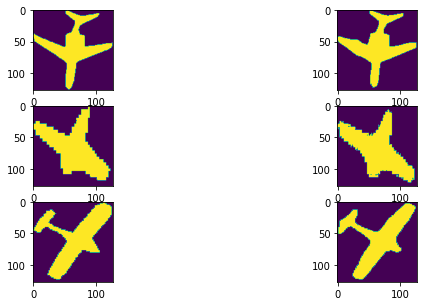

In [25]:
'''
# Visualize 3 sample outputs
# TODO: approx 5 lines
'''
from random import sample
fig, aix = plt.subplots(3,2)
i = 0
for (img, mask) in loader:
    print(img.size())
    img = img.cuda()
    mask = mask.cuda()
    pred = model(img)
    pred = F.relu(pred)
    pred = pred.squeeze().cpu().detach().numpy()
    pred = np.where(pred > 0, 1, 0)
#     aix[i][0].imshow(img[:,:,::-1].cpu())
    aix[i][0].imshow(mask.squeeze().cpu())
    aix[i][1].imshow(pred)
    i+=1
    if i > 2 : break

## Part 3: Instance Segmentation

In this part, you need to obtain the instance segmentation results for the test data by using the trained segmentation model in the previous part and the detection model in Part 1.

### Get Prediction

In [28]:
'''
# Define a new function to obtain the prediction mask by passing a sample data
# For this part, you need to use all the previous parts (predictor, get_instance_sample, data preprocessings, etc)
# It is better to keep everything (as well as the output of this funcion) on gpu as tensors to speed up the operations.
# pred_mask is the instance segmentation result and should have different values for different planes.
# TODO: approx 35 lines
'''
# set up detection model
from scipy.ndimage import label,find_objects
from torchvision.ops import remove_small_boxes
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.90
predictor_ = my_predictor(DefaultPredictor(cfg),512,512,256,0.20)

# set up segmentation detection model
model = MyModel().cuda()
model.load_state_dict(torch.load('{}/output/final_segmentation_model.pth'.format(BASE_DIR)))
model = model.eval()
img_trans = transforms.Compose([
              transforms.ToTensor(), # Converting the image to tensor and change the image format (Channels-Last => Channels-First)
              transforms.Normalize(mean=[0.45, 0.45, 0.45], std=[0.225, 0.225, 0.225]),
            ])
def get_prediction_mask(data):
    img = cv2.imread(data['file_name'])
#     print(data['file_name'])
    height = data['height']
    width = data['width']
    predictor = predictor_
    pred_mask =torch.tensor(np.zeros([height,width]), device = "cuda",dtype = torch.int32)
    gt_mask = torch.tensor(np.zeros([height,width]), device = "cuda",dtype = torch.int32)
    if len(data['annotations']) == 0:
        pass
    else:
        for id, ann in enumerate(data['annotations']):
            m = GenericMask(ann['segmentation'],height, width)
            gt_mask += (id+1)*torch.tensor(m.mask,device = "cuda") #(id+1)
    output = predictor.predict(img).pred_boxes.tensor.cuda()
    idx = 1
    for id , box in reversed(list(enumerate(output))):
        [x1,y1,x2,y2] = box
        [x1,y1,x2,y2] = [int(x1),int(y1),int(x2),int(y2)]
        img_crop = cv2.resize(img[y1:y2,x1:x2],(128,128),interpolation = cv2.INTER_AREA)
        img_crop = img_trans(img_crop)
        img_crop = img_crop[None,:,:,:].detach().clone().type(torch.float).cuda()
        obj_pred = model(img_crop)
        obj_mask = np.where(obj_pred.squeeze().cpu().detach().numpy() > 0, 1, 0)
        if not np.all(obj_mask == 0):
            obj_mask = obj_mask.astype("uint8")
            obj_mask = cv2.resize(obj_mask,(x2-x1,y2-y1),interpolation = cv2.INTER_NEAREST)
            obj_mask = obj_mask.astype("int32")
            obj_mask = torch.tensor(obj_mask,device = "cuda",dtype = torch.int32) # (id+1)
            for x in range(x1,x2):
                for y in range(y1,y2):
                    if(obj_mask[y-y1][x-x1] != 0):
                        pred_mask[y][x] = idx
            idx+=1
#     pred_labeled, lables = label(pred_mask.cpu().numpy())
#     pred_mask = torch.tensor(pred_labeled, dtype = torch.int32, device = "cuda")

    return img, gt_mask, pred_mask # gt_mask could be all zero when the ground truth is not given.


### Visualization and Submission

3


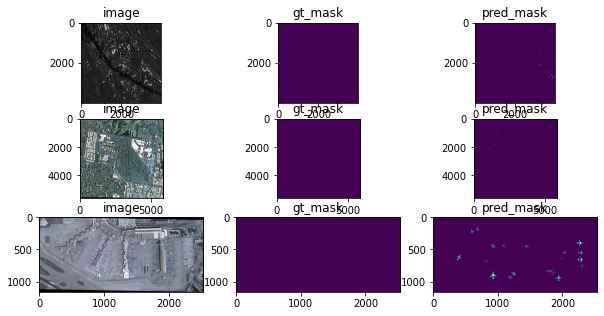

In [29]:
'''
# Visualise the output prediction as well as the GT Mask and Input image for a sample input
# TODO: approx 10 lines
'''

test_dicts = DatasetCatalog.get("data_detection_test")
fix, aix = plt.subplots(3,3)
id = 0
for sample in random.sample(test_dicts,3):
    img, gt_mask, pred_mask = get_prediction_mask(sample)
    aix[id,0].imshow(img)
    aix[id,0].title.set_text('image')
    aix[id,1].imshow(gt_mask.cpu())
    aix[id,1].title.set_text('gt_mask')
    aix[id,2].imshow(pred_mask.cpu())
    aix[id,2].title.set_text('pred_mask')
    cv2.imwrite("Visual1_{}.png".format(id),img)
    plt.imsave("Visual2_{}.png".format(id),pred_mask.cpu())
    id += 1
    if id > 2: break
print(id)


In [30]:
'''
# ref: https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
# https://www.kaggle.com/c/airbus-ship-detection/overview/evaluation
'''
def rle_encoding(x):
    '''
    x: pytorch tensor on gpu, 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = torch.where(torch.flatten(x.long())==1)[0]
    if(len(dots)==0):
      return []
    inds = torch.where(dots[1:]!=dots[:-1]+1)[0]+1
    inds = torch.cat((torch.tensor([0], device=torch.device('cuda'), dtype=torch.long), inds))
    tmpdots = dots[inds]
    inds = torch.cat((inds, torch.tensor([len(dots)], device=torch.device('cuda'))))
    inds = inds[1:] - inds[:-1]
    runs = torch.cat((tmpdots, inds)).reshape((2,-1))
    runs = torch.flatten(torch.transpose(runs, 0, 1)).cpu().data.numpy()
    return ' '.join([str(i) for i in runs])

In [31]:
'''
# You need to upload the csv file on kaggle
# The speed of your code in the previous parts highly affects the running time of this part
'''

preddic = {"ImageId": [], "EncodedPixels": []}

'''
# Writing the predictions of the training set
'''
my_data_list = DatasetCatalog.get("data_detection_{}".format('train'))
for i in tqdm(range(len(my_data_list)), position=0, leave=True):
  sample = my_data_list[i]
  sample['image_id'] = sample['file_name'].split("/")[-1][:-4]
  img, true_mask, pred_mask = get_prediction_mask(sample)
  inds = torch.unique(pred_mask)
  if(len(inds)==1):
    preddic['ImageId'].append(sample['image_id'])
    preddic['EncodedPixels'].append([])
  else:
    for index in inds:
      if(index == 0):
        continue
      tmp_mask = (pred_mask==index)
      encPix = rle_encoding(tmp_mask)
      preddic['ImageId'].append(sample['image_id'])
      preddic['EncodedPixels'].append(encPix)

'''
# Writing the predictions of the test set
'''

my_data_list = DatasetCatalog.get("data_detection_{}".format('test'))
for i in tqdm(range(len(my_data_list)), position=0, leave=True):
  sample = my_data_list[i]
  sample['image_id'] = sample['file_name'].split("/")[-1][:-4]
  img, true_mask, pred_mask = get_prediction_mask(sample)
  inds = torch.unique(pred_mask)
  if(len(inds)==1):
    preddic['ImageId'].append(sample['image_id'])
    preddic['EncodedPixels'].append([])
  else:
    for j, index in enumerate(inds):
      if(index == 0):
        continue
      tmp_mask = (pred_mask==index).double()
      encPix = rle_encoding(tmp_mask)
      preddic['ImageId'].append(sample['image_id'])
      preddic['EncodedPixels'].append(encPix)

pred_file = open("{}/pred.csv".format(BASE_DIR), 'w')
pd.DataFrame(preddic).to_csv(pred_file, index=False)
pred_file.close()

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

## Part 4: Mask R-CNN

For this part you need to follow a same procedure to part 2 with the configs of Mask R-CNN, other parts are generally the same as part 2.

### Data Loader

In [ ]:
cfg = get_cfg()
cfg.OUTPUT_DIR = "{}/output2/".format(BASE_DIR)
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("data_detection_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4 # Windows: 0, Linux 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 3 #in processed data
cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.TEST.EVAL_PERIOD = 1000

### Network

### Training

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

### Evaluation and Visualization

In [ ]:
print(cfg.OUTPUT_DIR)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
test_dict = get_detection_data('test')
fig, aix = plt.subplots(3,1,dpi=80)
idx = 0
for d in random.sample(test_dict,3):
    im = cv2.imread(d["file_name"])
    # ------------------ conv and merge here

    outputs = predictor(im)
    v = Visualizer(im[:, :, :],
                   metadata=plane_metadata,
                   scale=1.0,
                   instance_mode=ColorMode.IMAGE  # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs)
    aix[idx].imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB),origin='upper', interpolation='nearest')
    idx+=1
plt.show()



In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("data_detection_val", output_dir="./output2")
val_loader = build_detection_test_loader(cfg, "data_detection_val")
with open("inference.txt","w") as f:
    a = inference_on_dataset(DefaultPredictor(cfg).model, val_loader, evaluator)
    print(a)
    f.write(str(a))
    f.close()